In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:34 - loss: 0.0280 - STD: 7.5101e-05 - MAE: 0.1231

 4/64 [>.............................] - ETA: 1s - loss: 0.0187 - STD: 5.4621e-04 - MAE: 0.1067  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0171 - STD: 8.1445e-04 - MAE: 0.0887

10/64 [===>..........................] - ETA: 1s - loss: 0.0160 - STD: 0.0012 - MAE: 0.0835    

13/64 [=====>........................] - ETA: 1s - loss: 0.0154 - STD: 0.0017 - MAE: 0.0852

16/64 [======>.......................] - ETA: 1s - loss: 0.0149 - STD: 0.0021 - MAE: 0.0808

19/64 [=======>......................] - ETA: 1s - loss: 0.0145 - STD: 0.0026 - MAE: 0.0776

22/64 [=========>....................] - ETA: 1s - loss: 0.0142 - STD: 0.0032 - MAE: 0.0775

25/64 [==========>...................] - ETA: 0s - loss: 0.0138 - STD: 0.0041 - MAE: 0.0766

28/64 [============>.................] - ETA: 0s - loss: 0.0135 - STD: 0.0051 - MAE: 0.0743

31/64 [=============>................] - ETA: 0s - loss: 0.0131 - STD: 0.0066 - MAE: 0.0731

34/64 [==============>...............] - ETA: 0s - loss: 0.0128 - STD: 0.0088 - MAE: 0.0720

37/64 [================>.............] - ETA: 0s - loss: 0.0124 - STD: 0.0118 - MAE: 0.0702

40/64 [=================>............] - ETA: 0s - loss: 0.0119 - STD: 0.0158 - MAE: 0.0687

43/64 [===================>..........] - ETA: 0s - loss: 0.0115 - STD: 0.0203 - MAE: 0.0674

46/64 [====================>.........] - ETA: 0s - loss: 0.0110 - STD: 0.0247 - MAE: 0.0660

49/64 [=====================>........] - ETA: 0s - loss: 0.0106 - STD: 0.0283 - MAE: 0.0645

52/64 [=======================>......] - ETA: 0s - loss: 0.0102 - STD: 0.0313 - MAE: 0.0631

54/64 [========================>.....] - ETA: 0s - loss: 0.0101 - STD: 0.0334 - MAE: 0.0622

57/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0369 - MAE: 0.0610

60/64 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0399 - MAE: 0.0598

63/64 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0424 - MAE: 0.0587

64/64 [==============================] - 4s 45ms/step - loss: 0.0090 - STD: 0.0432 - MAE: 0.0584 - val_loss: 0.0047 - val_STD: 0.0703 - val_MAE: 0.0422


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0917 - MAE: 0.0357

 4/64 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0982 - MAE: 0.0361

 7/64 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0985 - MAE: 0.0359

10/64 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0977 - MAE: 0.0358

13/64 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0356

16/64 [======>.......................] - ETA: 1s - loss: 0.0031 - STD: 0.0981 - MAE: 0.0354

19/64 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0982 - MAE: 0.0353

22/64 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0983 - MAE: 0.0351

25/64 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0350

28/64 [============>.................] - ETA: 0s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0348

31/64 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.0987 - MAE: 0.0346

34/64 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0990 - MAE: 0.0345

37/64 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0344

40/64 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0989 - MAE: 0.0343

43/64 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0342

46/64 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0991 - MAE: 0.0341

49/64 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0992 - MAE: 0.0340

52/64 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0993 - MAE: 0.0339

55/64 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0994 - MAE: 0.0338

58/64 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0995 - MAE: 0.0336

61/64 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0996 - MAE: 0.0335

64/64 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0998 - MAE: 0.0334

64/64 [==============================] - 2s 27ms/step - loss: 0.0026 - STD: 0.0998 - MAE: 0.0334 - val_loss: 0.0025 - val_STD: 0.0847 - val_MAE: 0.0337


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0313

 4/64 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0310

 7/64 [==>...........................] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0308

10/64 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0306

13/64 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

16/64 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0305

19/64 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0304

22/64 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0303

25/64 [==========>...................] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0302

28/64 [============>.................] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

31/64 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0300

34/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0300

37/64 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0301

40/64 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0301

43/64 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1033 - MAE: 0.0301

46/64 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0302

49/64 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0302

52/64 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0301

55/64 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

58/64 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0301

61/64 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0300

64/64 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300

64/64 [==============================] - 2s 27ms/step - loss: 0.0019 - STD: 0.1031 - MAE: 0.0300 - val_loss: 0.0023 - val_STD: 0.0944 - val_MAE: 0.0333


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.1097 - MAE: 0.0293

 3/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0292

 6/64 [=>............................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0291

 9/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

12/64 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

15/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0290

18/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

21/64 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

24/64 [==========>...................] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0288

27/64 [===========>..................] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0288

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

33/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0287

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0286

48/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0286

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1045 - MAE: 0.0284 - val_loss: 0.0020 - val_STD: 0.0961 - val_MAE: 0.0306


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0279

 6/64 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0282

 9/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

12/64 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0281

14/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0281

17/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0280

20/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0281

23/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

26/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0280

29/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

32/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0280

35/64 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0281

38/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

41/64 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

44/64 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0281

47/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

50/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

53/64 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

56/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

59/64 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0280

62/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0280

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1049 - MAE: 0.0279 - val_loss: 0.0019 - val_STD: 0.0956 - val_MAE: 0.0295


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1070 - MAE: 0.0272

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0272

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0274

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0279

27/64 [===========>..................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

30/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0279

33/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0279

36/64 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0278

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

45/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

48/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0278

51/64 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

54/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0277

57/64 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0278 - val_loss: 0.0017 - val_STD: 0.0939 - val_MAE: 0.0286


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0272

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0276

 7/64 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

10/64 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0284

13/64 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0283

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0284

22/64 [=========>....................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

28/64 [============>.................] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

31/64 [=============>................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

34/64 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0281

37/64 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0280

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0279

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0279

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0277

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0276

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0276 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0283


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0271

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1062 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1059 - MAE: 0.0275

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0277

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1057 - MAE: 0.0279

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0280

25/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0281

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0281

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0280

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0281

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0280

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0279

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1050 - MAE: 0.0279 - val_loss: 0.0017 - val_STD: 0.0948 - val_MAE: 0.0286


Epoch 9/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0267

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

64/64 [==============================] - 2s 28ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268 - val_loss: 0.0015 - val_STD: 0.0912 - val_MAE: 0.0279


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0288

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0279

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0277

 9/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

12/64 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

15/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0272

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0269

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.0969 - val_MAE: 0.0286


Epoch 11/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0263

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1043 - MAE: 0.0262

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268 - val_loss: 0.0016 - val_STD: 0.0961 - val_MAE: 0.0282


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0265

 8/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

11/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

14/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

23/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0953 - val_MAE: 0.0280


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

17/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266

20/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

23/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0265

26/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

29/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

32/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

35/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

38/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

41/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

44/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

47/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0271

50/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0271

53/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

56/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

59/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0270

62/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0270 - val_loss: 0.0019 - val_STD: 0.0986 - val_MAE: 0.0301


Epoch 14/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1086 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0267

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0273

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0271

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0270

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0270

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0269

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0269

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0270

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0269

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0266 - val_loss: 0.0016 - val_STD: 0.0965 - val_MAE: 0.0278


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0262

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1041 - MAE: 0.0264

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0263

18/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

21/64 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

24/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

27/64 [===========>..................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

30/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

36/64 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

39/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

42/64 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0266

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268 - val_loss: 0.0021 - val_STD: 0.0995 - val_MAE: 0.0313


Epoch 16/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1095 - MAE: 0.0268

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0270

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0269

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0266

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0957 - val_MAE: 0.0277


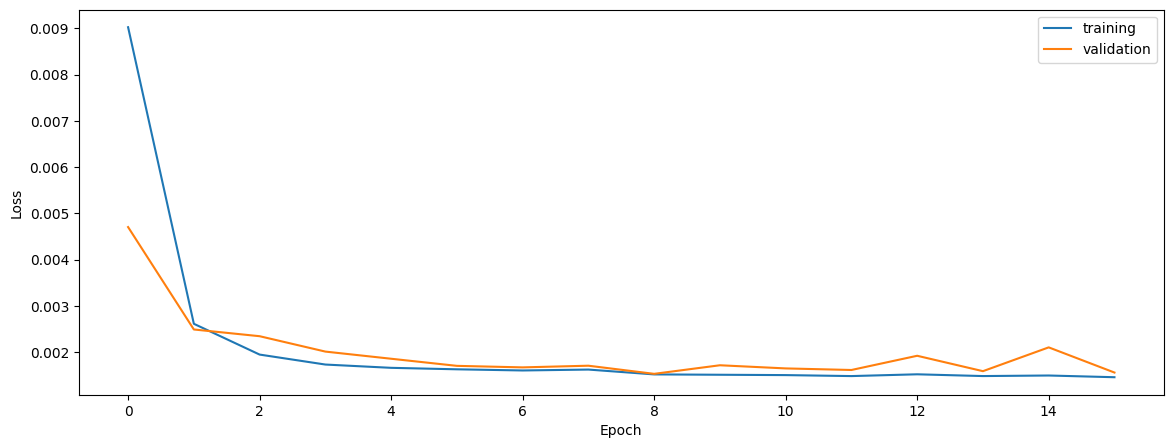

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9395497294459
0.9535102783415008
0.94898327597516


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9409218126969445
0.9512874989328965
0.9494022310831132


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9482452571144716
0.9534915700834768
0.9613230223313005


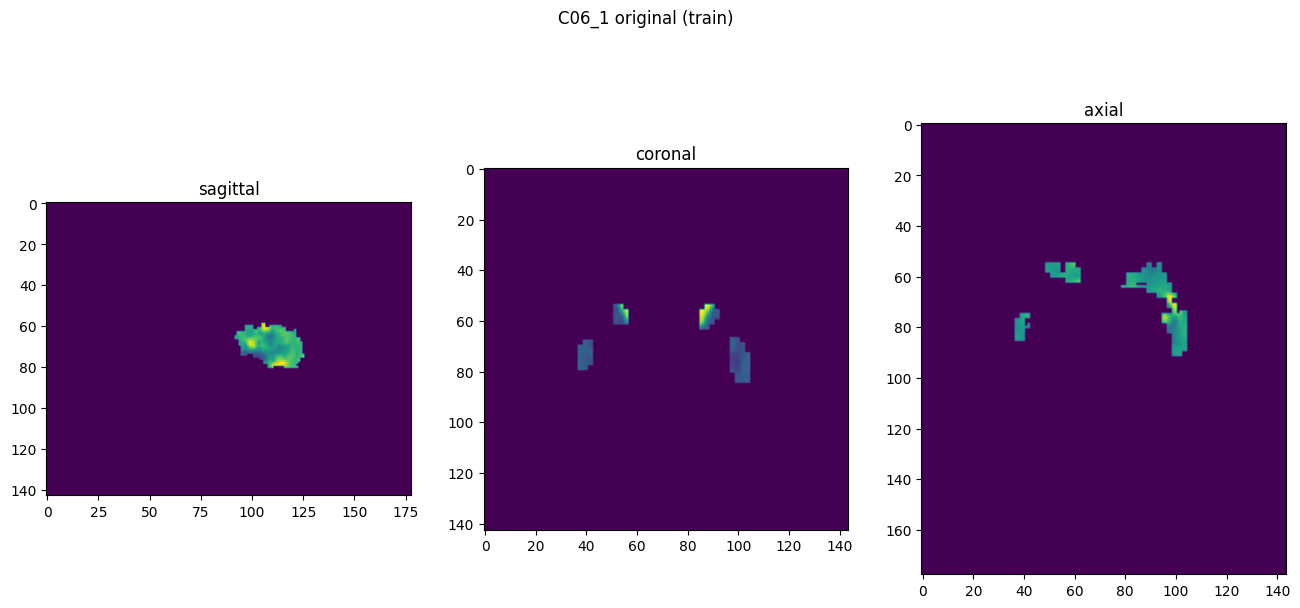

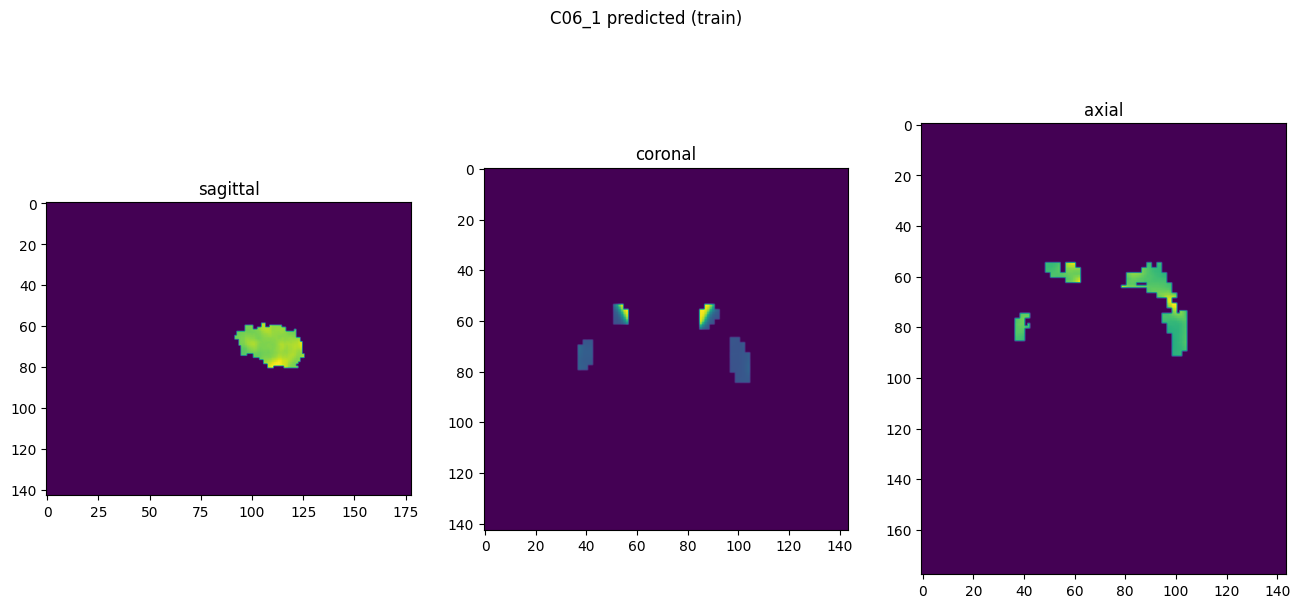

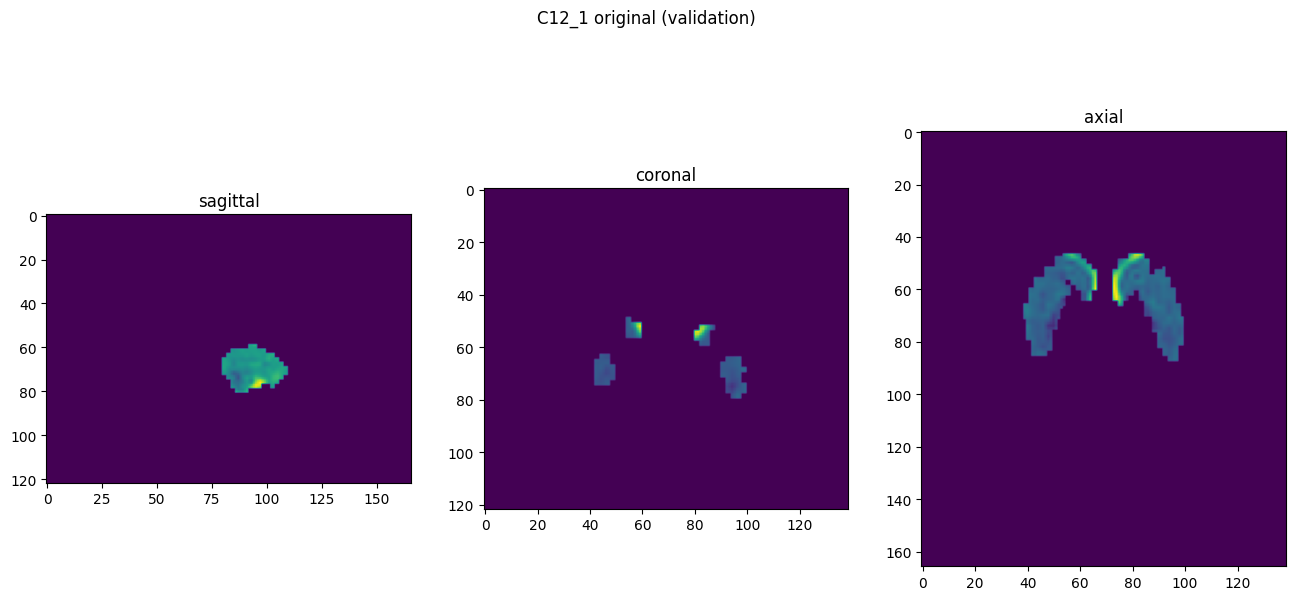

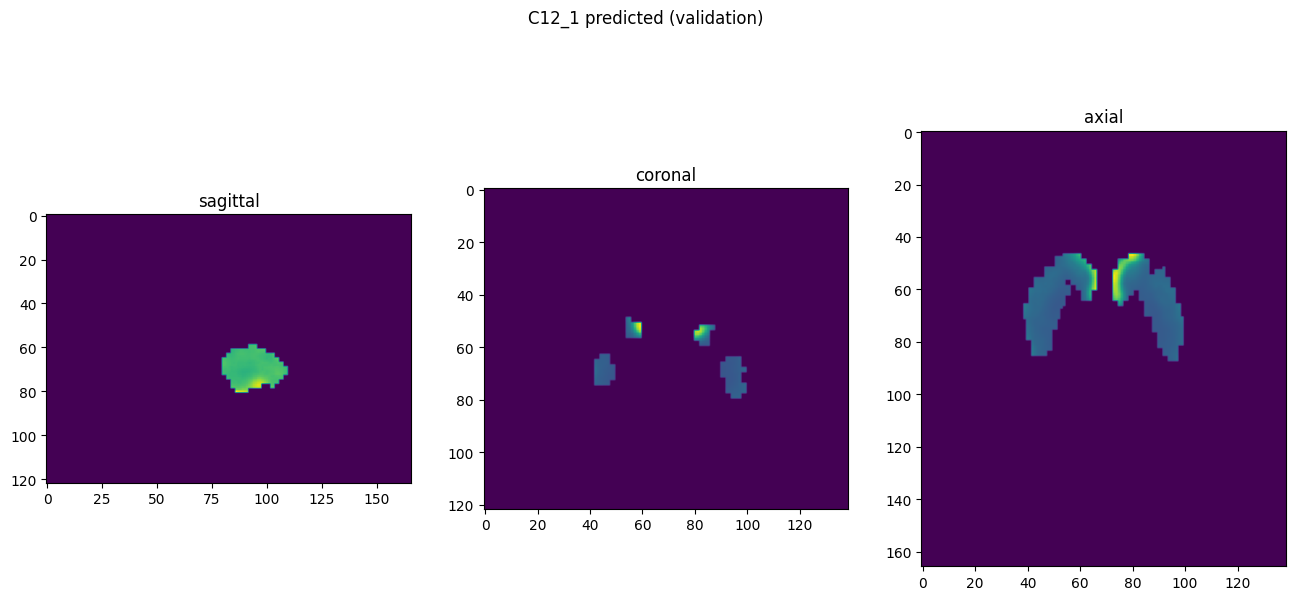

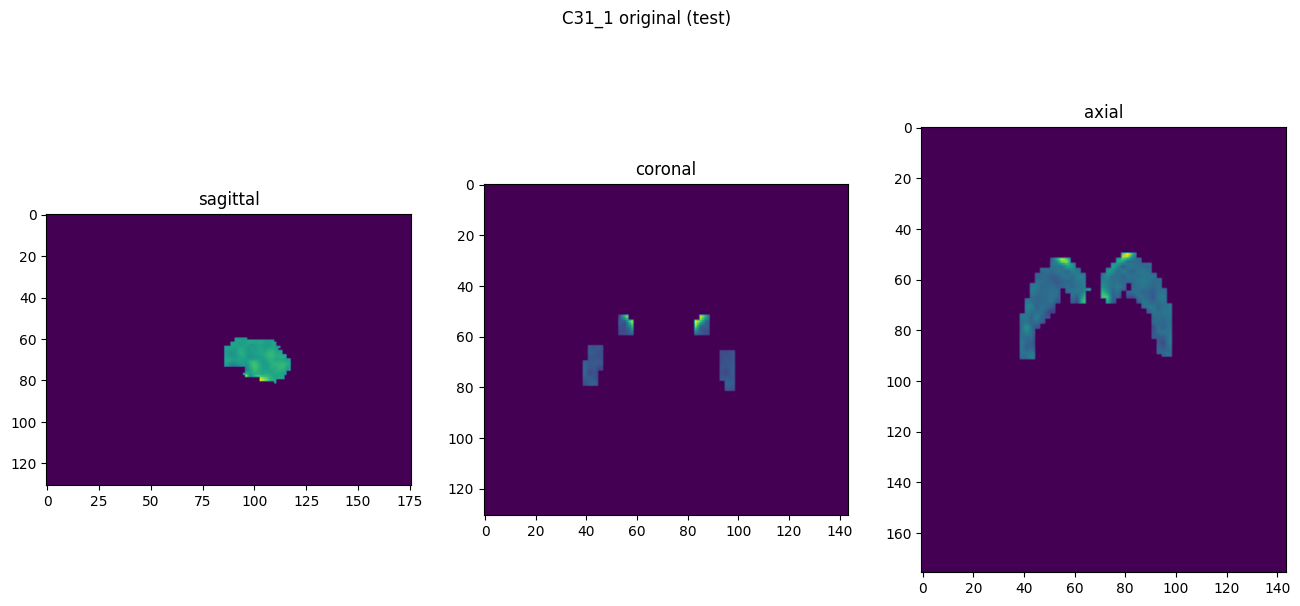

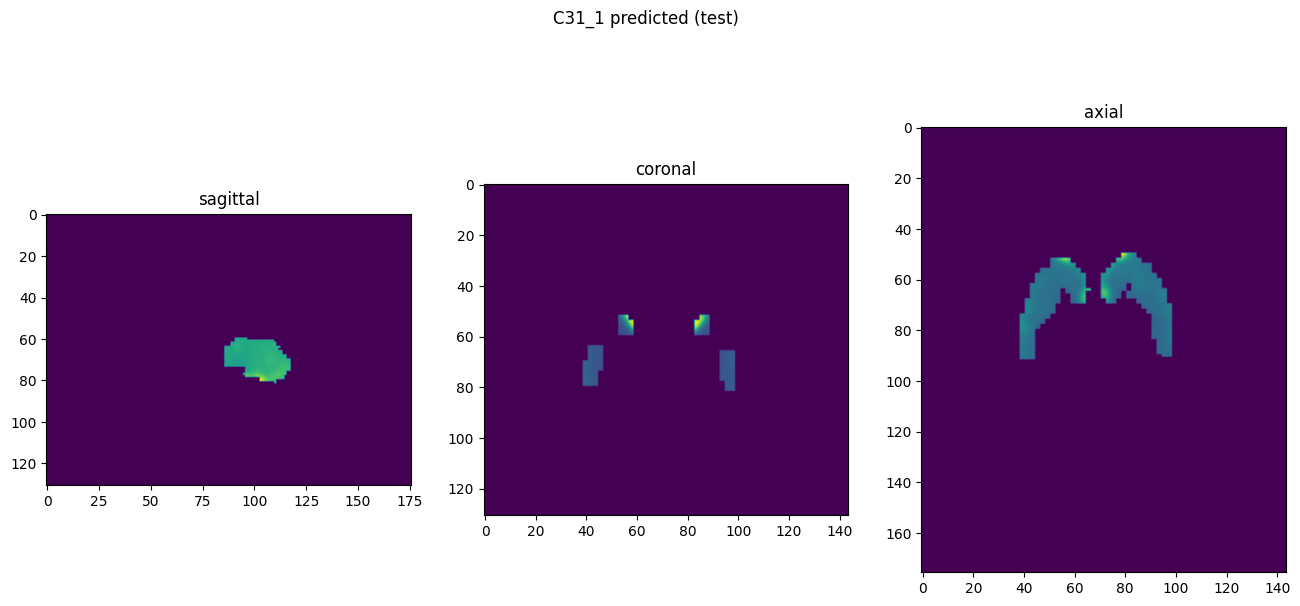

In [10]:
showResults(model, gen, threshold=None, background=False)